In [1]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import beta
import timeit
from scipy.optimize import minimize

# The true distribution
We take the true distribution of $y$ to be $\mathcal{Beta}(3,3)$ drawn on $[-1,1]$. i.e. we have unormalized density
<br>
<center> $(1+y)^2(1-y)^2$

We seek to find $x^*$ such that it solves $\min_x E[c(x,y)]$ where
<br>
<center>$c(x,y) = 3x^2 + 6xy^2 - 2x^2y - 7xy$.

This can be solved analytically, whereby $x$ is minimised at $-1/7$ = -0.14286.

In [2]:
# the cost function we would like to minimise
def f(x,y):
    return np.mean(3*(x**2) + 6*x*(y**2) - 2*(x**2)*y - 7*x*y,axis=0)

In [3]:
# the cost function we would like to minimise
def f2(x,y):
    return np.mean(3*(x**2) + 6*x*y**2 - 2*x**2*y - 7*x*y - 5*x,axis=0)

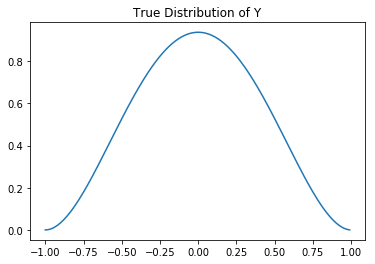

In [4]:
# Define the true distribution
Y = beta(a = 3,b=3,loc=-1,scale=2)

# plot the pdf within the range
x = np.arange (-1, 1, 0.01)
z = Y.pdf(x)
plt.plot(x,z)
plt.title("True Distribution of Y")

In [5]:
# Some experimental hyper parameters

# number of iterations to perform each experiment
n_iter = 10000

# number of samples for each experiment
# we use 50, 100, 150...., 5000 samples
N = [50,200, 800,3200]

In [6]:
def SSA_minimise(samples, func, p0=-1.0/7):
    res = minimize(func,p0,args=(samples),method='Nelder-Mead')
    return res.x

In [7]:
def KDE_minimise(samples, bandwidth, func, p0=-1.0/7, n_sample=20000):
    # fit using kde
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(np.reshape(samples,(-1,1)))
    
    # sample from fitted distribution
    KDE_samples = kde.sample(n_sample)
    
    # minimise the function
    res = minimize(func,p0,args=(KDE_samples),method='Nelder-Mead')
    return res.x

In [8]:
# bandwidths for kde
bandwidth = [0.01, 0.015, 0.02, 0.025]

In [9]:
SSA_results = np.zeros((n_iter,len(N)))
KDE_results = np.zeros((n_iter,len(N),len(bandwidth)))

start_time = timeit.default_timer()

for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])
    
        SSA_results[k,j] = SSA_minimise(S,f)
        for i in range(len(bandwidth)):
            KDE_results[k,j,i] = KDE_minimise(S, bandwidth[i], f)
        
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

This has taken 597.16 seconds


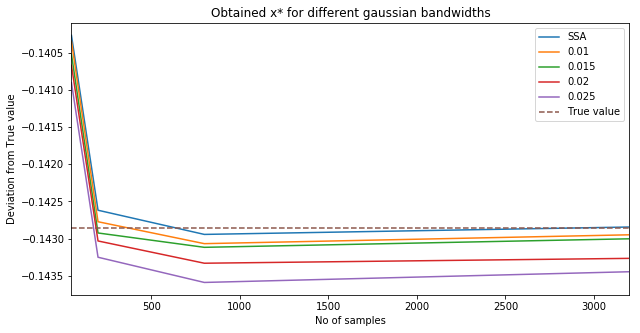

In [10]:
plt.figure(figsize=(10,5))
lineObjects = plt.plot(N,np.mean(SSA_results,axis=0),label='SSA approximation')
lineObjects += plt.plot(N,np.mean(KDE_results,axis=0))
lineObjects += plt.plot(N,[-1.0/7]*len(N),'--',label='True value')
plt.xlabel('No of samples')
plt.ylabel('Deviation from True value')
#plt.axvline(x=50,linestyle= '--')
#plt.axvline(x=200,linestyle= '--')
#plt.axvline(x=800,linestyle= '--')
plt.xlim([50,3200])
strings = [str(ele) for ele in bandwidth]
plt.legend(lineObjects,tuple(['SSA'] + strings + ['True value']))
plt.title('Obtained x* for different gaussian bandwidths')

In [11]:
from scipy.interpolate import interp1d
def get_hist(data,bins,ax,*args,**kwargs):
    vals, new_bins = np.histogram(data,normed=True,bins=bins)
    f = interp1d(new_bins[1:], vals)
    xnew = np.arange(np.min(new_bins[1:]), np.max(new_bins), 0.01)
    ynew = f(xnew)
    ax.plot(xnew,ynew,label=kwargs['label'])
    return new_bins

In [12]:
import pandas
df = pandas.DataFrame(KDE_results[:,0,:],columns=['0.01','0.015','0.02','0.025'])
df['SSA'] = SSA_results[:,0]

Some statistics of the obtained $x^*$ for each of the different bandwidth with $N=50$.

In [13]:
df.describe()

,0.01,0.015,0.02,0.025,SSA
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.140352,-0.140525,-0.140672,-0.140904,-0.140269
std,0.062126,0.062099,0.062040,0.062049,0.061991
min,-0.358315,-0.357757,-0.363058,-0.367020,-0.363058
25%,-0.183259,-0.183217,-0.183036,-0.183426,-0.182533
50%,-0.141350,-0.141211,-0.141434,-0.141853,-0.141155
75%,-0.099595,-0.099777,-0.100223,-0.100321,-0.099498
max,0.111105,0.106306,0.110826,0.107143,0.106752


### Pdf

We plot the histograms of $x^*$ for each sample size. It doesn't show why there is a significant bias for bandwidth values greater than 0.02...

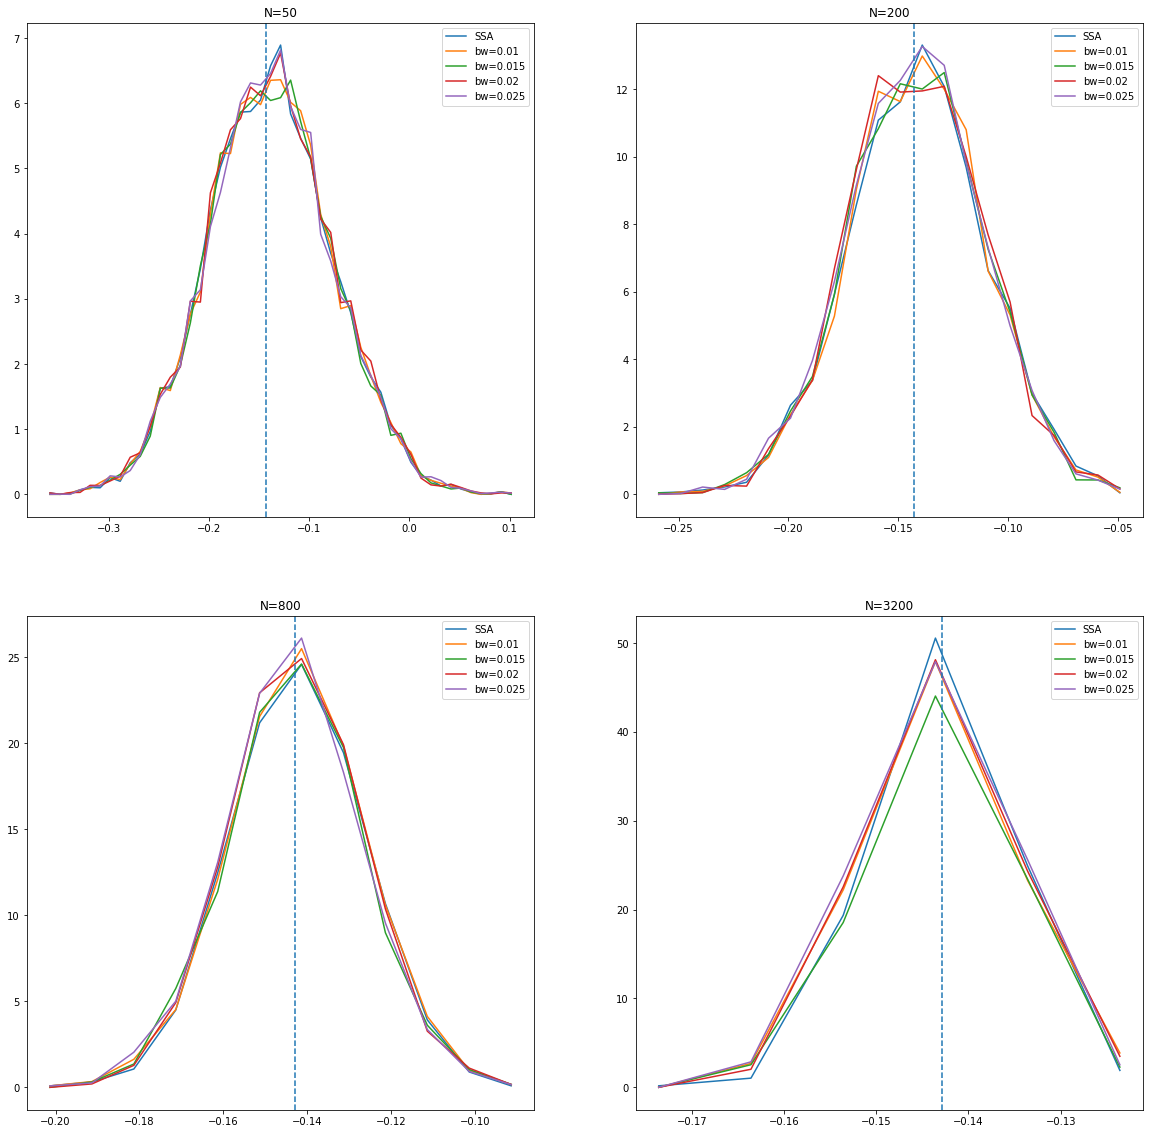

In [14]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
ax = np.reshape(ax,(-1))
for i in range(4):
    bins = get_hist(SSA_results[:,i],100,ax[i],label='SSA')
    for k in range(len(bandwidth)):
        get_hist(KDE_results[:,i,k],bins,ax[i],label='bw='+str(bandwidth[k]))
    ax[i].axvline(x=-1.0/7,linestyle= '--')
    ax[i].set_title('N='+str(N[i]))
    ax[i].legend()

# Try with different function

In [15]:
SSA_results = np.zeros((n_iter,len(N)))
KDE_results = np.zeros((n_iter,len(N),len(bandwidth)))

start_time = timeit.default_timer()

for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])
    
        SSA_results[k,j] = SSA_minimise(S,f2)
        for i in range(len(bandwidth)):
            KDE_results[k,j,i] = KDE_minimise(S, bandwidth[i], f2)
        
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

This has taken 990.85 seconds


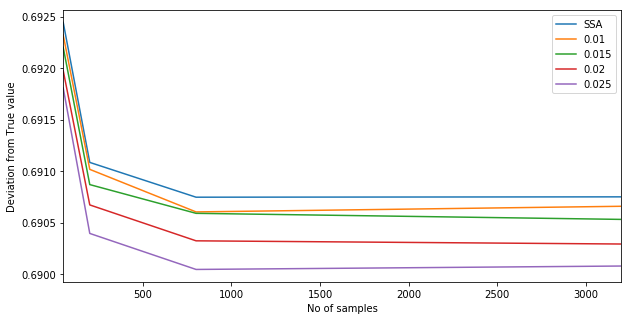

In [16]:
plt.figure(figsize=(10,5))
lineObjects = plt.plot(N,np.mean(SSA_results,axis=0),label='SSA approximation')
lineObjects += (plt.plot(N,np.mean(KDE_results,axis=0)))
#plt.plot(N,[-1.0/7]*len(N),'--',label='True value')
plt.xlabel('No of samples')
plt.ylabel('Deviation from True value')
#plt.axvline(x=50,linestyle= '--')
#plt.axvline(x=200,linestyle= '--')
#plt.axvline(x=800,linestyle= '--')
plt.xlim([50,3200])
strings = [str(ele) for ele in bandwidth]
plt.legend(lineObjects,tuple(['SSA'] + strings))

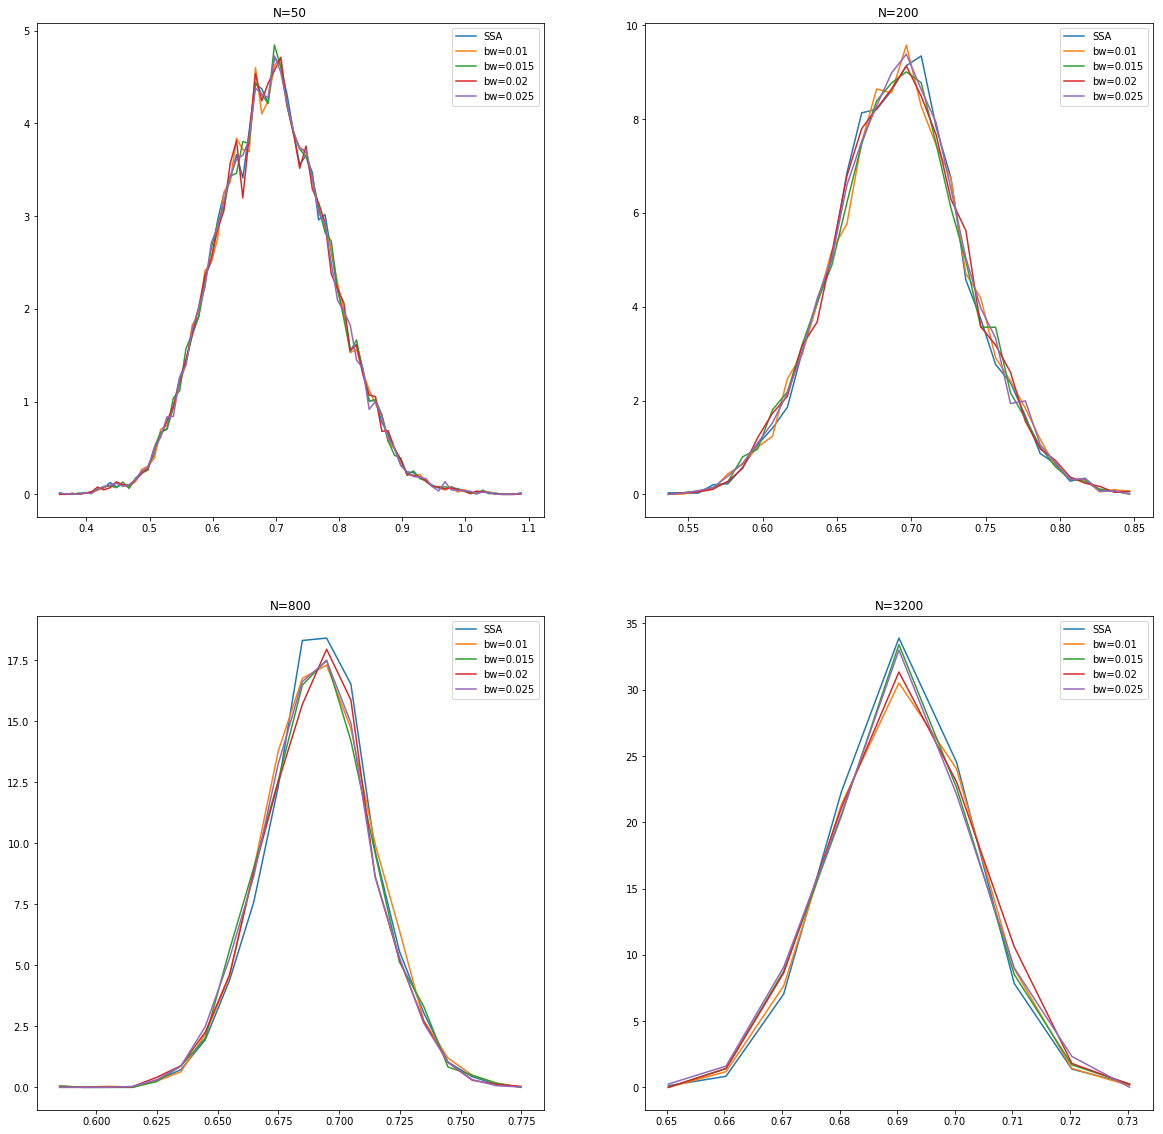

In [20]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
ax = np.reshape(ax,(-1))
for i in range(4):
    bins = get_hist(SSA_results[:,i],100,ax[i],label='SSA')
    for k in range(len(bandwidth)):
        get_hist(KDE_results[:,i,k],bins,ax[i],label='bw='+str(bandwidth[k]))
    #ax[i].axvline(x=-1.0/7,linestyle= '--')
    ax[i].set_title('N='+str(N[i]))
    ax[i].legend()

In [18]:
import pandas
df = pandas.DataFrame(KDE_results[:,0,:],columns=['0.01','0.015','0.02','0.025'])
df['SSA'] = SSA_results[:,0]
df.describe()

,0.01,0.015,0.02,0.025,SSA
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.692322,0.692202,0.691977,0.691808,0.692445
std,0.091009,0.091079,0.090990,0.090932,0.090878
min,0.341964,0.353013,0.347210,0.355692,0.350167
25%,0.630022,0.629060,0.629353,0.629241,0.629688
50%,0.691602,0.691574,0.690960,0.690820,0.691462
75%,0.752902,0.752916,0.752469,0.751967,0.752790
max,1.090960,1.095480,1.102176,1.091908,1.092969
